In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import copy
from torchvision import models
import torch.nn.functional as F
from sklearn import metrics
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler 
import matplotlib.pyplot as plt
import seaborn as sns
from deepctr_torch.layers.interaction import CrossNet
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix
from datetime import timedelta
from tableone import TableOne
from sklearn.model_selection import train_test_split

2022-05-13 17:50:07.412521: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/opt/slurm/slurm-20.11.0/lib64:
2022-05-13 17:50:07.412623: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Prep data

In [2]:
path = '/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/'
data = pd.read_csv(path + '1.0/small/dataset2.csv', index_col = 'hadm_id')
cohort = pd.read_csv(path + '1.0/small/train_test_split.csv', index_col='hadm_id')

In [3]:
cohort.head()

,subject_id,outcome,dicom_id,test
hadm_id,,,,
25557012,18148913,1,44492b23-7b8ede65-186035fe-18b0d023-062931d2,0
24817845,12249989,1,d296a85a-d1923dce-df563d85-c8ddcbe1-c48de10a,0
24508472,16743897,1,4caa047b-0d1ab83b-923a8eb7-f767b1c9-5a9e79b7,0
29718793,15175605,1,e5da67c2-8f7c401f-dab09bb4-0005b035-88d58590,0
21975130,19088387,1,d665772d-91ea781a-7d27a671-acac7b29-9f1051ea,0


In [3]:
df = data.merge(cohort[['test', 'outcome']], left_index = True, right_index = True).drop(
                                                            ['hours_since_admit'], axis = 1)

In [4]:
##create train and test splits
X_train = df[df['test'] == 0]
X_train.drop(['test', 'outcome'], axis = 1, inplace = True)
y_train = df['outcome'][df['test']==0]

X_test =  df[df['test'] == 1]
X_test.drop(['test','outcome'], axis = 1, inplace = True)
y_test = df['outcome'][df['test']==1]

/tmp/ipykernel_419118/2869630485.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['test', 'outcome'], axis = 1, inplace = True)
/tmp/ipykernel_419118/2869630485.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['test','outcome'], axis = 1, inplace = True)


In [5]:
## create scaler and apply only to numeric data before adding binary data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train.iloc[:,:-5])
X_train_norm = pd.DataFrame(X_train_norm, index = X_train.index, columns = X_train.columns[:-5])
X_train_norm = X_train_norm.merge(X_train.iloc[:,-5:], left_index = True, right_index = True)

##apply scaler to test data
X_test_norm = scaler.transform(X_test.iloc[:,:-5])
X_test_norm = pd.DataFrame(X_test_norm, index = X_test.index, columns = X_test.columns[:-5])
X_test_norm = X_test_norm.merge(X_test.iloc[:,-5:], left_index = True, right_index = True)

In [6]:
##check correlation
corrs = X_test_norm.merge(y_test, left_index = True, right_index = True).corr()['outcome']

## Cohort information

In [5]:
#extract demographic features
path = '/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/1.0/'
patients = pd.read_csv(path + 'core/patients.csv', parse_dates = ['anchor_year'])
admissions = pd.read_csv(path + 'core/admissions.csv', parse_dates = ['admittime'])
icustays = pd.read_csv(path + 'small/icu/icustays.csv', parse_dates = ['intime', 'outtime'])

In [10]:
demographics = patients.merge(admissions, on = 'subject_id')
demographics = demographics.merge(icustays, on=['subject_id','hadm_id'])

In [11]:
demographics_used = demographics[(demographics['hadm_id'].isin(X_train.index))| (demographics['hadm_id'].isin(X_test.index))]
demographics_used['age'] = demographics_used ['anchor_age']+(demographics_used ['admittime'] - demographics_used['anchor_year'])/timedelta(days = 365)


/tmp/ipykernel_232935/1162025142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics_used['age'] = demographics_used ['anchor_age']+(demographics_used ['admittime'] - demographics_used['anchor_year'])/timedelta(days = 365)


In [18]:
#replace location with either medical or surgical unit
locations = {'Medical/Surgical Intensive Care Unit (MICU/SICU)':'MICU',
       'Trauma SICU (TSICU)':'SICU', 'Coronary Care Unit (CCU)':'MICU',
       'Medical Intensive Care Unit (MICU)':'MICU',
       'Cardiac Vascular Intensive Care Unit (CVICU)':'MICU',
       'Surgical Intensive Care Unit (SICU)':'SICU',
       'Neuro Surgical Intensive Care Unit (Neuro SICU)':'SICU',
       'Neuro Stepdown':'SICU'}
demographics_used['first_careunit'] = demographics_used['first_careunit'].replace(locations)

/tmp/ipykernel_232935/2778731297.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics_used['first_careunit'] = demographics_used['first_careunit'].replace(locations)


In [20]:
demographics_used.columns

Index(['subject_id', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'dod', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status',
       'ethnicity', 'edregtime', 'edouttime', 'hospital_expire_flag',
       'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime',
       'los', 'age'],
      dtype='object')

In [60]:
table_one = demographics_used[['hadm_id','gender','age','ethnicity','hospital_expire_flag', 'los', 'first_careunit', 'insurance']]
outcomes = pd.concat([train_id, test_id])[['hadm_id', 'outcome']]
table_one = table_one.merge(outcomes, on = ['hadm_id'])
table_one.rename(columns = {'hospital_expire_flag':'death'}, inplace = True)

ethnicity_map = {'UNABLE TO OBTAIN':'OTHER', 'UNKNOWN':'OTHER', 'AMERICAN INDIAN/ALASKA NATIVE':'OTHER'}
table_one['ethnicity'] = table_one['ethnicity'].map(ethnicity_map).fillna(table_one['ethnicity'])


In [66]:
columns = ['gender','age','ethnicity', 'first_careunit']
categorical = ['gender','ethnicity', 'first_careunit']
groupby = ['outcome']
mytable = TableOne(table_one, columns , categorical, groupby, missing = False)

/gpfs/commons/home/aelhussein/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/gpfs/commons/home/aelhussein/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/gpfs/commons/home/aelhussein/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby in

In [67]:
mytable

Grouped by outcome                          
                                                        Overall            0            1
n                                                          8433         7190         1243
gender, n (%)         F                             3764 (44.6)  3238 (45.0)   526 (42.3)
                      M                             4669 (55.4)  3952 (55.0)   717 (57.7)
age, mean (SD)                                      66.4 (15.7)  66.2 (15.9)  67.9 (14.9)
ethnicity, n (%)      ASIAN                           234 (2.8)    212 (2.9)     22 (1.8)
                      BLACK/AFRICAN AMERICAN        1171 (13.9)  1019 (14.2)   152 (12.2)
                      HISPANIC/LATINO                 315 (3.7)    263 (3.7)     52 (4.2)
                      OTHER                         1196 (14.2)  1004 (14.0)   192 (15.4)
                      WHITE                         5517 (65.4)  4692 (65.3)   825 (66.4)
first_careunit, n (%) MICU                          5804 (68.8)  4967 (69.1)   837 (67.3)
                      SICU                          2629 (31.2)  2223 (30.9)   406 (32.7)

## EHR neural network

In [7]:
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size[0])
            self.relu1 = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size[0], self.hidden_size[1])
            self.relu2 = torch.nn.ReLU()
            self.fc3 = torch.nn.Linear(self.hidden_size[1], self.hidden_size[2])
            self.relu3 = torch.nn.ReLU()
            self.fc4 = torch.nn.Linear(self.hidden_size[2], 1)
            self.sigmoid = torch.nn.Sigmoid()
            
            self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu1(hidden)
            relu = self.dropout(relu)
            hidden = self.fc2(relu)
            relu = self.relu2(hidden)
            relu = self.dropout(relu)
            hidden = self.fc3(relu)
            relu = self.relu3(hidden)
            relu = self.dropout(relu)
            output = self.fc4(relu)
            output = self.sigmoid(output)
            return output

In [8]:
## initialize model
model = Feedforward(X_train_norm.shape[1], [128,64,32])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0005)

## of steps to take
total_step = X_train_norm.shape[0]

#create dictionaries for accuracy, probabilities and labels
train_accuracy = {}
train_probabilites = {}
train_labels = {}

test_accuracy = {}
test_probabilites = {}
test_labels = {}
num_epochs = 500
#copy the initial weights of the model
best_model_wts = copy.deepcopy(model.state_dict())
best_model_params = copy.deepcopy(optimizer.state_dict())
best_auc_train = 0.0
best_auc_test = 0.0

In [10]:
#run model
model_train = torch.tensor(X_train_norm.values)
model_test = torch.tensor(X_test_norm.values)
#for epoch in range(num_epochs):
for epoch in range(num_epochs):
    #train the model on the train set
    outputs = model(model_train.float())
    loss = criterion(outputs.squeeze(1), torch.tensor(y_train.values).float())
    
    #apply backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #auc
    fpr, tpr, thresholds = metrics.roc_curve(y_train.values, outputs.detach().numpy())
    AUC = metrics.auc(fpr, tpr)
    if AUC > best_auc_train:
        best_auc_train = AUC

    
    #Check accuracy in the test set
    with torch.no_grad():
        outputs = model(model_test.float())
        loss = criterion(outputs.squeeze(1), torch.tensor(y_test.values).float())

        #calculate AUC for best epoch
        fpr, tpr, thresholds = metrics.roc_curve(y_test.values, outputs.detach().numpy())
        AUC = metrics.auc(fpr, tpr)
        
        if AUC > best_auc_test:
            best_auc_test = AUC
            best_model_wts = copy.deepcopy(model.state_dict())
            best_opt_params = copy.deepcopy(optimizer.state_dict())
            best_loss = copy.deepcopy(loss)
            fpr_best, tpr_best, thresholds_best = fpr, tpr, thresholds
            labels, predicted_prob = y_test.values, outputs.detach().numpy().reshape(1,-1)
            

            
path = '/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/1.0/small/model_params/best_model_params_EHR.pt'
state = { 'epoch': epoch,
    #'state_dict': best_model_wts,
    'optimizer': best_opt_params,
    'loss': best_loss}
torch.save(state, path)

In [11]:
##save results
ehr_results = {'fpr': fpr_best,
               'tpr': tpr_best,
               'thresholds': thresholds_best}

ehr_results_df = pd.DataFrame.from_dict(ehr_results)
ehr_results_df.to_csv('/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/1.0/small/results/EHR_only.csv')

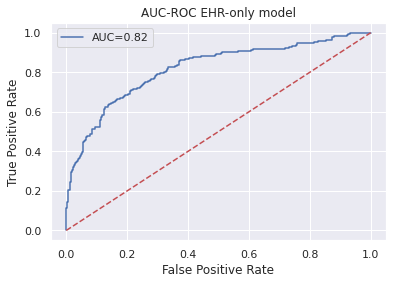

In [12]:
##plot results
sns.set_theme()
plt.plot(fpr_best,tpr_best, label="AUC="+str(round(best_auc_test,2)))
plt.plot([0,1],[0,1], linestyle = '--', color = 'r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.title('AUC-ROC EHR-only model')
plt.show()

## CXR Image processing



In [7]:
#Define the model in pytorch using resnet32
class CNN_CXR(nn.Module):
    def __init__(self):
        super(CNN_CXR, self).__init__()
        ##import resnet
        self.model = torchvision.models.resnet34(pretrained=True)
        ##create new binary classifier (normal vs. pneumonia)
        classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features,256),
            nn.Linear(256,32),
            nn.Linear(32,1),
            nn.Sigmoid())
        #Allow only fc parameters to be updated using the new model
        for params in self.model.parameters():
            params.requires_grad = False
        #Replace the output function with this classifier
        self.model.fc = classifier
    #Retain the same forward pass architecture in ResNet    
    def forward(self,x):
        return self.model(x)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Processor: {}'.format(device))

#Transform the images 
mean_vals = 0.443
std_vals=0.32

torch.manual_seed(0)
transformers = {'train_transforms' : transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, std=std_vals)
]),
'test_transforms' : transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, std=std_vals)
])}



#Load the images (batch loading)
trans = ['train_transforms','test_transforms']
path = "/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/1.0/small/cxr/"
categories = ['train','test']
dset = {x : torchvision.datasets.ImageFolder(path+x, transform=transformers[y]) for x,y in zip(categories, trans)}
dataset_sizes = {x : len(dset[x]) for x in ["train", 'test']}
dataloaders =  {x : torch.utils.data.DataLoader(dset[x], batch_size=256, shuffle=True) for x in categories}


##initialize model and optimizer
model = CNN_CXR()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
model = model.to(device)


##load best model from pretraining
#path = '/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/1.0/chest_xray/best_model_params.pt'
#state = torch.load(path)
#model.load_state_dict(state['state_dict'])
#optimizer.load_state_dict(state['optimizer'])
#model.train()


#loss function is BCELoss
criterion  = nn.BCELoss()


## of steps to take
total_step = dataset_sizes['train']

#create dictionaries for accuracy, probabiliteis and labels
train_accuracy = {}
train_probabilites = {}
train_labels = {}
test_accuracy = {}
test_probabilites = {}
test_labels = {}


#copy the initial weights of the model
best_model_wts = copy.deepcopy(model.state_dict())
best_auc_train = 0.0
best_auc_test = 0.0

Processor: cuda


In [9]:
#run model
num_epochs = 20
for epoch in range(num_epochs):
    #train the model on the train set
    correct_train = 0
    total_images_train = 0
    train_images_probabilites = []
    train_images_labels = []
    for i, (images, labels) in enumerate(dataloaders['train']):
        #move to cpu or gpu depending on processing unit
        images = images.to(device)
        labels = labels.to(device)
        #run model
        outputs = model(images)
        #wrangle output and labels and apply loss function
        outputs = outputs.reshape((1,-1))[0]
        labels = labels.to(torch.float32)
        loss = criterion(outputs, labels)
        #store the model probabilites for being in class 1 for AUC
        prob = outputs.tolist()
        train_images_probabilites.extend(prob)
        train_images_labels.extend(labels.tolist())
        #assess accuracy of the train set
        predicted = np.round(prob)
        correct_train += np.where(predicted.astype(int) == np.array(labels.tolist()))[0].shape[0]
        total_images_train += labels.size(0)
        #apply backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy[epoch] = 100*(correct_train/total_images_train)
    train_probabilites[epoch] = train_images_probabilites
    train_labels[epoch] = train_images_labels
    
    #calculate AUC for best epoch
    fpr, tpr, thresholds = metrics.roc_curve(train_labels[epoch], train_probabilites[epoch])
    AUC_train = metrics.auc(fpr, tpr)
    
    print('Train: {}'.format(AUC_train))
          
    if AUC_train > best_auc_train:
        best_auc_train = AUC_train
    
        #Check accuracy in the test set
    with torch.no_grad():
        correct_test = 0
        total_images_test = 0
        test_images_probabilites = []
        test_images_labels = []
          
        for images, labels in dataloaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            outputs = outputs.reshape((1,-1))[0]
            labels = labels.to(torch.float32)
            loss = criterion(outputs, labels)

            prob = outputs.tolist()
            test_images_probabilites.extend(prob)
            test_images_labels.extend(labels.tolist())
            
            ##assess accuracy
            predicted = np.round(prob)
            correct_test += np.where(predicted.astype(int) == np.array(labels.tolist()))[0].shape[0]
            total_images_test += labels.size(0)

        test_accuracy[epoch] = 100*(correct_test/total_images_test)
        test_probabilites[epoch] = test_images_probabilites
        test_labels[epoch] = test_images_labels
        
        #calculate AUC for best epoch
        fpr, tpr, thresholds = metrics.roc_curve(test_labels[epoch], test_probabilites[epoch])
        AUC_test = metrics.auc(fpr, tpr)
        print('Test: {}'.format(AUC_test))
    
        #ensure we keep the best performing model in the test set for future use
        if AUC_test > best_auc_test:
            best_auc_test = AUC_test
            best_model_wts = copy.deepcopy(model.state_dict())
            best_opt_params = copy.deepcopy(optimizer.state_dict())
            best_loss = loss
            fpr_best, tpr_best, thresholds_best = fpr, tpr, thresholds
            path = '/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/1.0/small/model_params/best_model_params_CXR.pt'
            state = { 'epoch': epoch,
                'state_dict': best_model_wts,
                'optimizer': best_opt_params,
                'loss': best_loss}
            torch.save(state, path)

Train: 0.49576771143634246
Test: 0.5082012056649738
Train: 0.49893310452013995
Test: 0.5754676080763037
Train: 0.5324932003626475
Test: 0.6299393038523473
Train: 0.576084704053879
Test: 0.6400243610388539
Train: 0.6342471830073825
Test: 0.6341405508072174
Train: 0.6445275871001166
Test: 0.6379495437466451
Train: 0.656383240512887
Test: 0.6417895041083446
Train: 0.6666966714156197
Test: 0.6367211693298649
Train: 0.6669829037689419
Test: 0.6403133903133903
Train: 0.6760685144411345
Test: 0.6417585366860731
Train: 0.6626735526486206
Test: 0.6423056278128741
Train: 0.6533635539437896
Test: 0.6406746769065611
Train: 0.667072918015801
Test: 0.6372992278789381
Train: 0.6644113456806113
Test: 0.644524959742351
Train: 0.6537443336355394
Test: 0.642635946983773
Train: 0.6380650174847817
Test: 0.6422746603906024
Train: 0.6720975262271727
Test: 0.6422436929683307
Train: 0.6872704312912835
Test: 0.6440294809860027
Train: 0.6839891205802358
Test: 0.637020521078492
Train: 0.6489586841082762
Test: 0.6

In [23]:
##save results
cxr_results = {'fpr': fpr_best,
               'tpr': tpr_best,
               'thresholds': thresholds_best}

cxr_results_df = pd.DataFrame.from_dict(cxr_results)
cxr_results_df.to_csv('/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/1.0/small/results/cxr_only.csv')

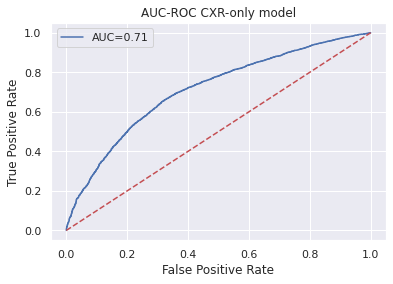

In [25]:
##Plot AUC-ROC
sns.set_theme()
plt.plot(fpr_best,tpr_best, label="AUC="+str(round(best_auc_train,2)))
plt.plot([0,1],[0,1], linestyle = '--', color = 'r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.title('AUC-ROC CXR-only model')
plt.show()

## Multimodal

In [121]:
class DeepCross(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
            super(DeepCross, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.cross = CrossNet(self.input_size, layer_num = 3)
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size[0])
            self.relu1 = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size[0], self.hidden_size[1])
            self.relu2 = torch.nn.ReLU()
            self.fc3 = torch.nn.Linear(self.hidden_size[1], self.hidden_size[2])
            self.relu3 = torch.nn.ReLU()
            self.fc4 = torch.nn.Linear(self.hidden_size[2], 32)
            self.relu4 = torch.nn.ReLU()
            self.fc5 = torch.nn.Linear(self.hidden_size[2] + self.input_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
       
            self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
            output_cross = self.cross(x)
            hidden = self.fc1(x)
            relu = self.relu1(hidden)
            relu = self.dropout(relu)
            hidden = self.fc2(relu)
            relu = self.relu2(hidden)
            relu = self.dropout(relu)
            hidden = self.fc3(relu)
            relu = self.relu3(hidden)
            relu = self.dropout(relu)
            hidden = self.fc4(relu)
            relu = self.relu4(hidden)
            relu = self.dropout(relu)
            output = torch.cat((relu, output_cross), dim = 1)
            output = self.fc5(output)
            output = self.sigmoid(output)
            return output

In [122]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
## multimodal model (32 vector from cxr added to the ehr data)
model_all = DeepCross(X_res.shape[1]+32, [128,64,32])
optimizer_all = torch.optim.Adam(model_all.parameters(), lr = 0.001, weight_decay = 0.005)
criterion = torch.nn.BCELoss()

## of steps to take
total_step = X_res.shape[0]

#create dictionaries for accuracy, probabilities and labels
train_accuracy = {}
train_probabilites = {}
train_labels = {}

test_accuracy = {}
test_probabilites = {}
test_labels = {}
num_epochs = 500

#copy the initial weights of the model
best_model_wts = copy.deepcopy(model_all.state_dict())
best_model_params = copy.deepcopy(optimizer_all.state_dict())
best_auc_train = 0.0
best_auc_test = 0.0

In [69]:
#Define the model in pytorch using multimodal
class CNN_CXR_multimodal(nn.Module):
    def __init__(self):
        super(CNN_CXR_multimodal, self).__init__()
        ##import resnet
        self.model = torchvision.models.resnet34(pretrained=True)
        ##create new binary classifier (normal vs. pneumonia)
        classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features,128),
            nn.Linear(128,2),
            nn.LogSoftmax(dim =1))
        #Allow all parameters to be updated using the new model
        for params in self.model.parameters():
            params.requires_grad = False
        #Replace the output function with this classifier
        self.model.fc = classifier
    #Retain the same forward pass architecture in ResNet    
    def forward(self,x):
        return self.model(x)

In [144]:
##load model
model_img = CNN_CXR_multimodal()
optimizer_img = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.005)
path = '/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/1.0/chest_xray/best_model_params.pt'
state = torch.load(path)
model_img = model_img.to(device)
model_img.load_state_dict(state['state_dict'])
optimizer_img.load_state_dict(state['optimizer'])

##update model to take the 32-shaped vector
model_img.model.fc = nn.Sequential(
                    nn.Linear(512,32))

#Transform the images 
mean_vals = 0.500
std_vals=0.349

torch.manual_seed(0)
transformers = {'train_transforms' : transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, std=std_vals)
]),
'test_transforms' : transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, std=std_vals)
])}



#Load the images (batch loading)
trans = ['train_transforms','test_transforms']
path = "/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/1.0/small/cxr/"
categories = ['train','test']
dset = {x : torchvision.datasets.ImageFolder(path+x, transform=transformers[y]) for x,y in zip(categories, trans)}
dataset_sizes = {x : len(dset[x]) for x in ["train", 'test']}
dataloaders =  {x : torch.utils.data.DataLoader(dset[x], batch_size=128, shuffle=True) for x in categories}


## create dictionary of samples to save as using oversampling in train set
samples= dataloaders['train'].dataset.samples
samples = [sam for sam, _ in samples]
sample_dict = {}
for sample in samples:
    sample_dict[sample.split('/')[-1].replace('.jpg','')] = 0

## create dicom_id to hadm_id mapper
dicom_hadm_mapper = dict(zip(split['dicom_id'],split['hadm_id']))

In [ ]:
##run model
for epoch in range(40):
    # save image vectors to pass to main model
    image_vectors = []
    #train the imaging model on the train set
    for i, (images, labels) in enumerate(dataloaders['train']):
        images = images.to(device)
        labels = labels.to(device)
        outputs_img = model_img(images)
        #run model and extract
        image_vectors.extend(outputs_img.cpu().detach().numpy())
        
    ##fill sample dict with cxr vectors
    for i in range(len(sample_dict.keys())):
        sample_dict[list(sample_dict.keys())[i]] = image_vectors[i]
        
    ## create dataframe of cxr vectors and add in the hadm_id
    imgv = pd.DataFrame.from_dict(sample_dict, orient = 'index', columns= ['imgv_{}'.format(i+1) for i in range(128)])
    s = imgv.index.to_series()
    imgv.index = s.map(dicom_hadm_mapper)  
    
    ##create new datasets that include the EHR and CXR vectors
    input_data_train = X_res.merge(imgv, left_index = True, right_index = True, how = 'left')
    y_res_2 = y_res[list(input_data_train['imgv_23'].notnull())]
    input_data_train_2 = input_data_train[input_data_train['imgv_23'].notnull()]
    input_data_test = X_test_norm.merge(imgv, left_index = True, right_index = True, how = 'left')
    y_test_2 = y_test[list(input_data_test['imgv_23'].notnull())]
    input_data_test_2 = input_data_test[input_data_test['imgv_23'].notnull()]


    ##move datasets to gpu
    model_train = torch.tensor(input_data_train_2.values)
    model_test = torch.tensor(input_data_test_2.values)
    model_train = model_train.to(device)
    model_test = model_test.to(device)
    y_res_2 = torch.tensor(y_res_2.values).to(device)
    y_test_2 = torch.tensor(y_test_2.values).to(device)
    ##run model
    outputs = model_all(model_train.float())
    loss = criterion(outputs.squeeze(1), y_res_2.float())
    ##apply backward propagation full data
    optimizer_all.zero_grad()
    loss.backward(retain_graph=True)
    optimizer_all.step()
    ##apply backward propagation imaging model
    optimizer_img.zero_grad()
    loss.backward(retain_graph=True)
    optimizer_img.step()

    #auc
    fpr, tpr, thresholds = metrics.roc_curve(y_res_2.cpu().detach().numpy(), outputs.cpu().detach().numpy())
    AUC = metrics.auc(fpr, tpr)
    print('Train: {}'.format(AUC))
    if AUC > best_auc_train:
        best_auc_train = AUC
        
    #Check accuracy in the test set
    with torch.no_grad():
        outputs = model_all(model_test.float())
        loss = criterion(outputs.squeeze(1), y_test_2.float())

        #calculate AUC for best epoch
        fpr, tpr, thresholds = metrics.roc_curve(y_test_2.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        AUC = metrics.auc(fpr, tpr)
        print('Test: {}'.format(AUC))
        if AUC > best_auc_test:
            best_auc_test = AUC
            fpr_best, tpr_best, thresholds_best = fpr, tpr, thresholds
            labels, predicted_prob = y_test_2.cpu().detach().numpy(), outputs.cpu().detach().numpy().reshape(1,-1)


In [145]:
##save results
combined_results = {'fpr': fpr_best,
               'tpr': tpr_best,
               'thresholds': thresholds_best}


combined_results_df = pd.DataFrame.from_dict(combined_results)
combined_results_df.to_csv('/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/1.0/small/results/Combined.csv')

predicted_output = {'label': labels, 'predicted': predicted_prob[0]}
predicted_output_df = pd.DataFrame.from_dict(predicted_output)
predicted_output_df.to_csv('/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/1.0/small/results/Combined_probs.csv')

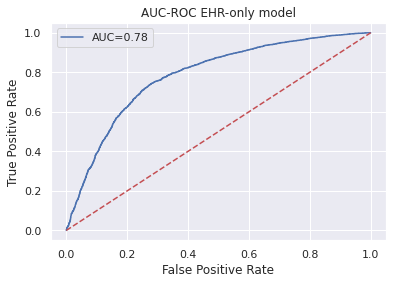

In [105]:
##print results
sns.set_theme()
plt.plot(fpr_best,tpr_best, label="AUC="+str(round(best_auc_train,2)))
plt.plot([0,1],[0,1], linestyle = '--', color = 'r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.title('AUC-ROC EHR-only model')
plt.show()

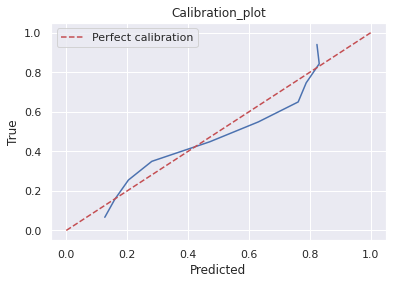

In [146]:
##calibration plot
prob_true, prob_pred = calibration_curve(predicted_output_df['label'], predicted_output_df['predicted'], n_bins=10)
sns.set_theme()
plt.plot(prob_true, prob_pred)
plt.plot([0,1],[0,1], linestyle = '--', color = 'r', label = 'Perfect calibration')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.legend()
plt.title('Calibration_plot')
plt.show()

In [17]:
predicted_output_df = pd.read_csv('/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/1.0/small/results/Combined_probs.csv')

In [18]:
predicted_class = np.where(predicted_output_df['predicted'] > 0.5, 1, 0)
confusion_matrix_50 = confusion_matrix(predicted_output_df['label'], predicted_class)

In [19]:
confusion_df = pd.DataFrame(confusion_matrix_50, index = ['Pred_Negative', 'Pred_Postive'], columns = ['Actual_Negative', 'Actual_Postive'])

In [40]:
confusion_df

,Actual_Negative,Actual_Postive
index,,
Pred_Negative,891,60
Pred_Postive,299,133


In [20]:
confusion_df.to_csv('/gpfs/commons/groups/gursoy_lab/aelhussein/ML_project/1.0/small/results/Combined_confusion_matrix.csv')

## Random forest (sanity check)

In [133]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
clf = RandomForestClassifier(max_depth=8, random_state=0)
clf.fit(X_train_norm, y_train)
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, clf.predict_proba(X_test_norm)[:,1])
AUC = metrics.auc(fpr, tpr)
AUC

0.7899686196787644